Analyzing the continuous ratings from all rehearsals and all performances  

In [2]:
import matplotlib.pyplot as plt 
%matplotlib inline 
import numpy as np 

import os 

In [3]:
filepath = '/home/brain/Desktop/BrainSongs/audiosummary_private/christopherocher/'
listfiles = os.listdir(filepath)
listnpz = []
for c in listfiles:
    if c[-3:] == 'npz':
        listnpz.append(os.path.join(filepath,c))

In [3]:
listnpz

['/home/brain/Desktop/BrainSongs/audiosummary_private/christopherocher/caroleeg_sess3.npz',
 '/home/brain/Desktop/BrainSongs/audiosummary_private/christopherocher/caroleeg_sess5_2.npz',
 '/home/brain/Desktop/BrainSongs/audiosummary_private/christopherocher/caroleeg_sess5_1.npz',
 '/home/brain/Desktop/BrainSongs/audiosummary_private/christopherocher/caroleeg_sess2.npz',
 '/home/brain/Desktop/BrainSongs/audiosummary_private/christopherocher/caroleeg_sess4_1.npz',
 '/home/brain/Desktop/BrainSongs/audiosummary_private/christopherocher/caroleeg_sess6.npz',
 '/home/brain/Desktop/BrainSongs/audiosummary_private/christopherocher/caroleeg_sess4_3.npz',
 '/home/brain/Desktop/BrainSongs/audiosummary_private/christopherocher/caroleeg_sess4_2.npz',
 '/home/brain/Desktop/BrainSongs/audiosummary_private/christopherocher/caroleeg_perf1.npz',
 '/home/brain/Desktop/BrainSongs/audiosummary_private/christopherocher/caroleeg_perf2.npz']

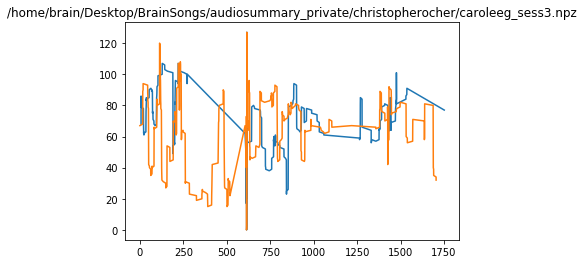

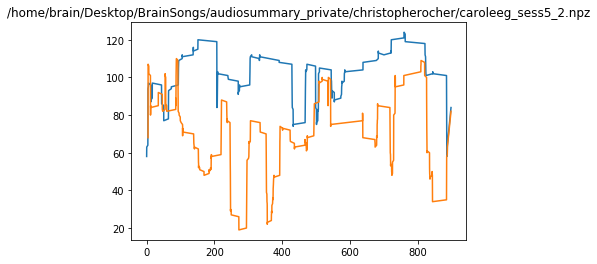

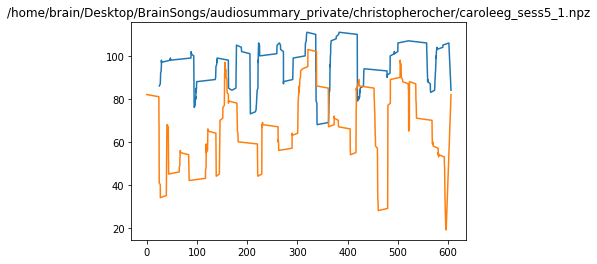

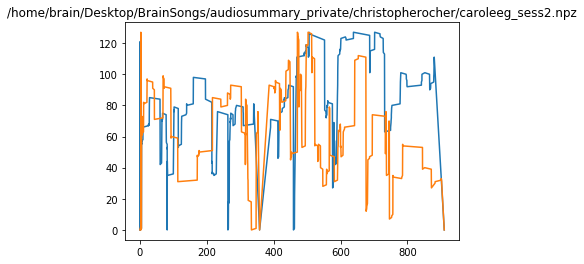

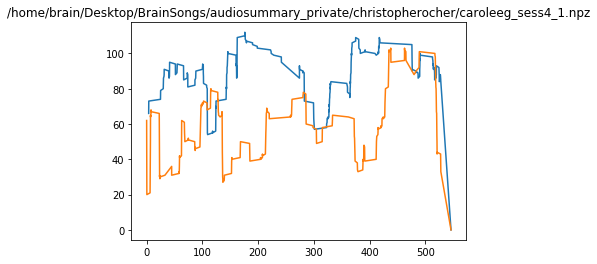

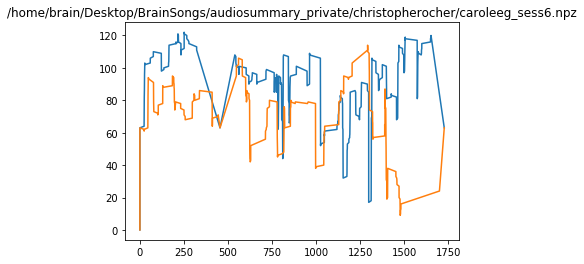

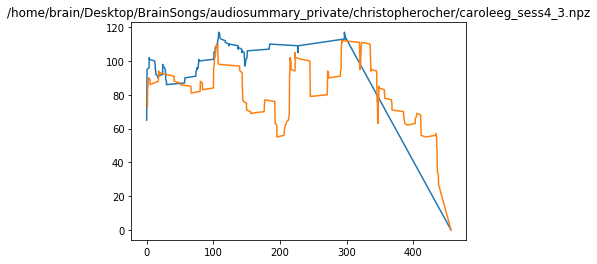

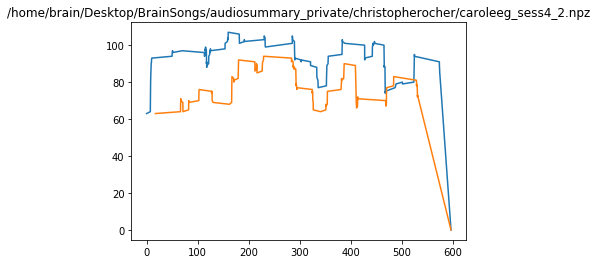

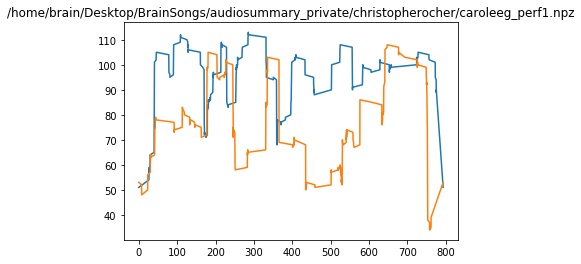

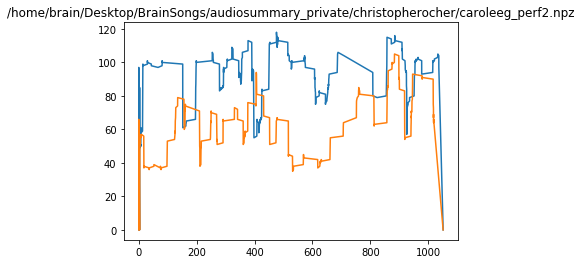

In [4]:
for curnpz in listnpz:
    focus = np.load(curnpz)['focus']
    subjtime = np.load(curnpz)['subjtime']
    plt.plot(focus[:,0],focus[:,1])
    plt.plot(subjtime[:,0],subjtime[:,1])
    plt.title(curnpz)
    plt.show()
    

Quantization

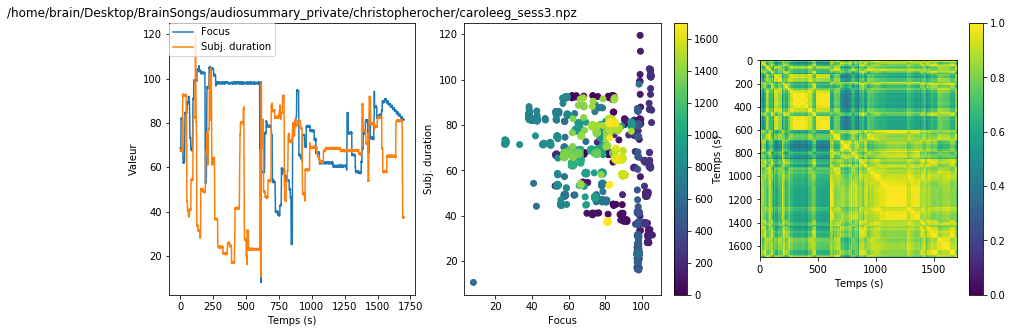

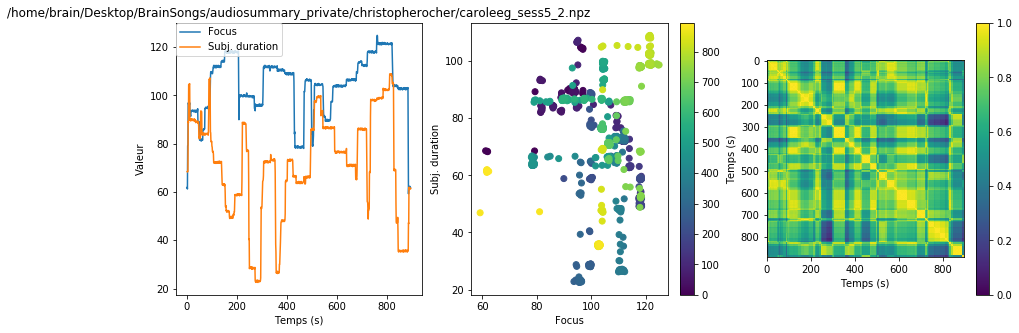

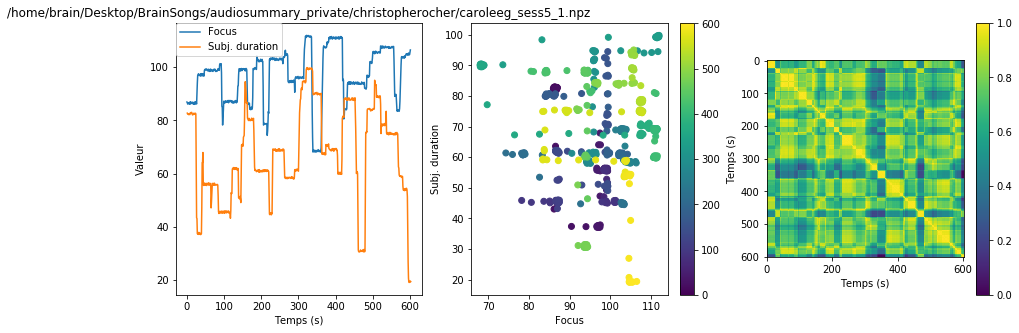

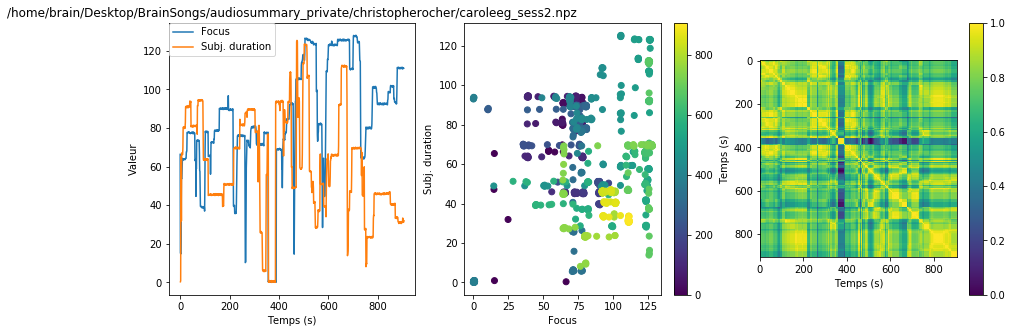

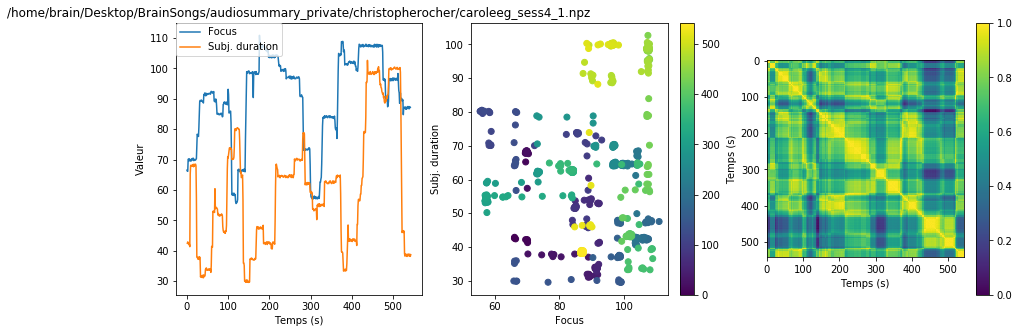

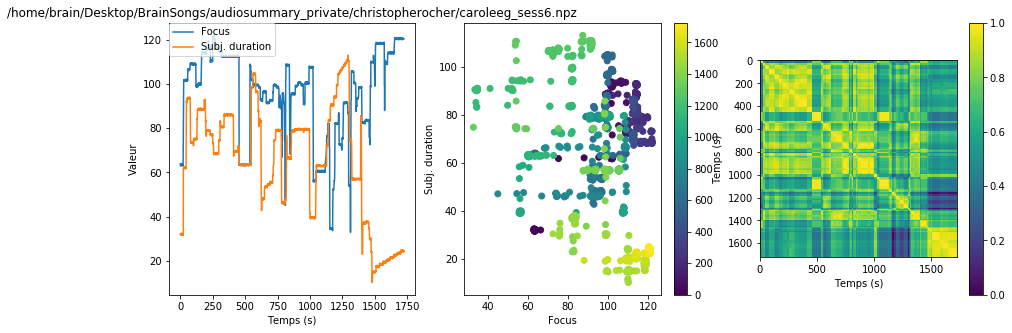

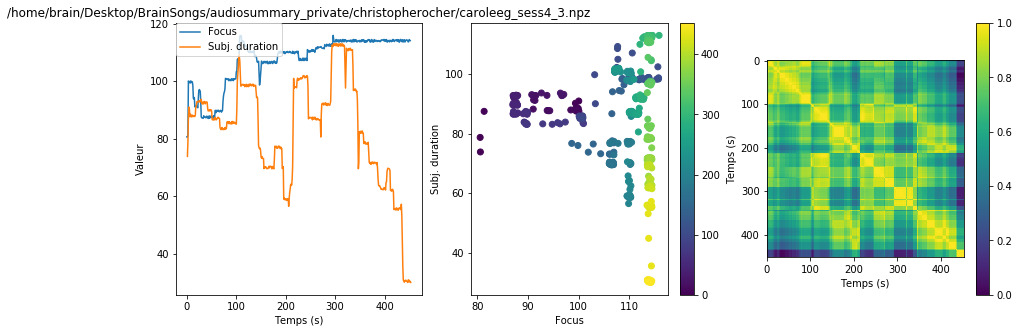

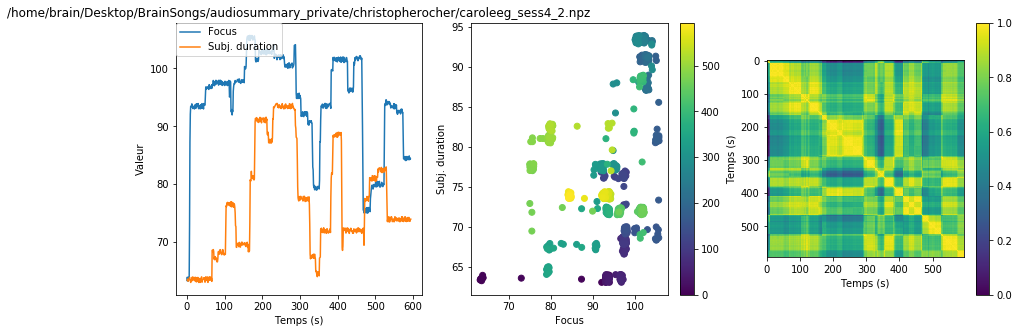

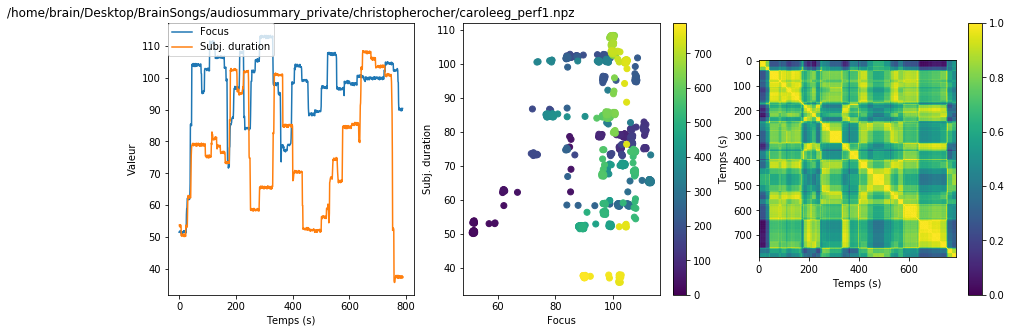

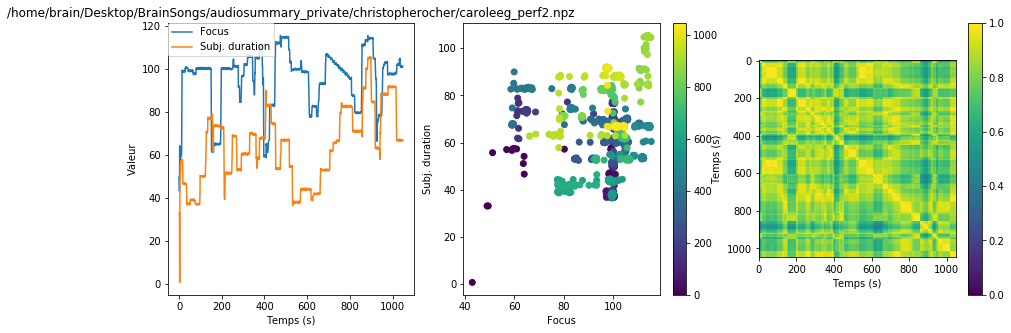

In [5]:
from analysis import quantize
from analysis import write_clustered_segments

from sklearn.metrics.pairwise import cosine_similarity,manhattan_distances,paired_manhattan_distances


addnoise = True  

allX = []
lengths = []

for curnpz in listnpz:
    focus = np.load(curnpz)['focus']
    
    subjtime = np.load(curnpz)['subjtime']

    #Quantization
    focus_q = quantize(focus,res=1,delaytime=0) 
    subt_q = quantize(subjtime,res=1,delaytime=1)

  
    
    maxtime = min(focus_q.shape[0],subt_q.shape[0])

    if addnoise:
        focus_q[:maxtime,1] += np.random.rand(maxtime)
        subt_q[:maxtime,1] += np.random.rand(maxtime)
    
    X = np.stack([focus_q[:maxtime,1],subt_q[:maxtime,1]]).T
    
    allX.append(X)
    lengths.append(X.shape[0])
    
    S = manhattan_distances(X)

    
    
    plt.figure(figsize=(15,5))
    plt.subplot(1,3,1)
    plt.plot(focus_q[:maxtime,0],focus_q[:maxtime,1],label="Focus")
    plt.plot(subt_q[:maxtime,0],subt_q[:maxtime,1],label="Subj. duration")
    plt.ylabel('Valeur')
    plt.xlabel('Temps (s)')
    plt.legend(loc=2, borderaxespad=0.)
    plt.title(curnpz)
    
    plt.subplot(1,3,2)
    plt.scatter(focus_q[:maxtime,1],subt_q[:maxtime,1],c=np.arange(maxtime))
    plt.xlabel('Focus')
    plt.ylabel('Subj. duration')
    
    plt.colorbar()
    
    
    plt.subplot(1,3,3)
    
    plt.imshow((np.max(S)-S)/np.max(S))
    plt.xlabel('Temps (s)')
    plt.ylabel('Temps (s)')
    plt.colorbar()
    
    plt.savefig('%s.png' % curnpz)
    plt.show()
    
    

allX = np.vstack(allX)

KMEANS
--

100%|██████████| 13/13 [00:25<00:00,  2.00s/it]


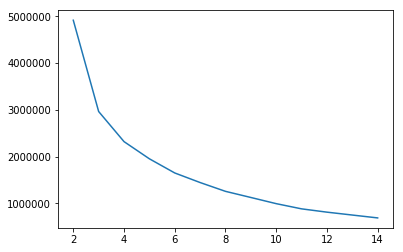

In [9]:
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score

from tqdm import tqdm
inertia = []
sil = []
maxclu= 15
for nclust in tqdm(range(2,maxclu)):
    mykmeans = KMeans(n_clusters=nclust)


    mykmeans.fit(allX)

    sil.append(silhouette_score(allX,mykmeans.labels_))
    inertia.append((mykmeans.inertia_))
    
    
plt.plot(range(2,maxclu),inertia)

In [10]:
allX.shape

(9256, 2)

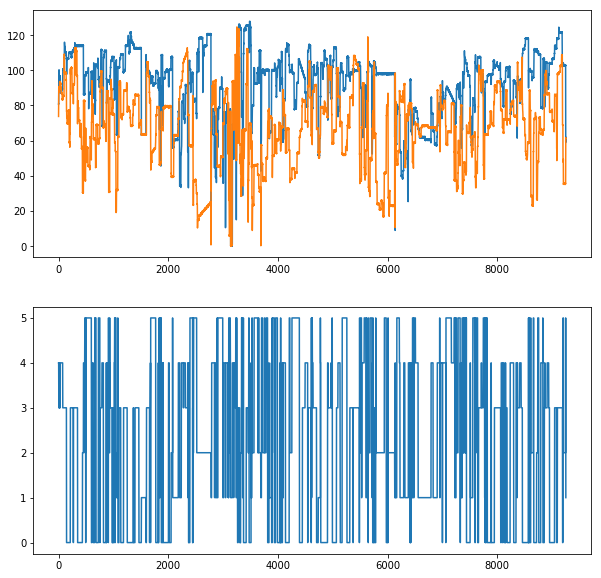

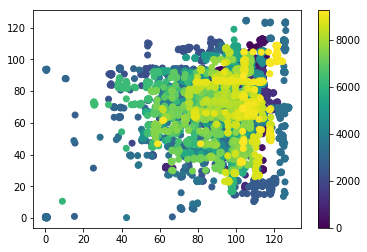

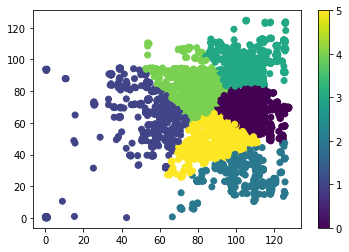

In [11]:
from sklearn.cluster import KMeans
kmeans_allperf = KMeans(n_clusters=6)

mint = 0
maxt=9250

allX = np.vstack(allX)

kmeans_allperf.fit(allX)

subjectivementalstates = kmeans_allperf.labels_

plt.figure(figsize=(10,10))
plt.subplot(2,1,1)
plt.plot(allX[mint:maxt,0])
plt.plot(allX[mint:maxt,1])
plt.subplot(2,1,2)
plt.plot(subjectivementalstates[mint:maxt])
plt.show()


plt.scatter(allX[mint:maxt,0],allX[mint:maxt,1],c=np.arange(maxt))
plt.colorbar()
plt.show()

plt.scatter(allX[mint:maxt,0],allX[mint:maxt,1],c=subjectivementalstates[mint:maxt])
plt.colorbar()
plt.show()


Apply the clustering learnt across all performances on individual performances to extract representative sound examples

In [12]:
from analysis import write_clustered_segments

for curnpz in listnpz:
    focus = np.load(curnpz)['focus']
    
    subjtime = np.load(curnpz)['subjtime']

    #Quantization
    focus_q = quantize(focus,res=1,delaytime=0) 
    subt_q = quantize(subjtime,res=1,delaytime=1)
    
    maxtime = min(focus_q.shape[0],subt_q.shape[0])
    
    X = np.stack([focus_q[:maxtime,1],subt_q[:maxtime,1]]).T
    
    
    currentlabels = kmeans_allperf.predict(X)
        
    inputfile = curnpz[:-3] + 'wav'
    labels_pred = currentlabels
    seglength = 1
        
    analysis_name = curnpz[55:-4]
    resultpath = '/home/nfarrugi/datasets/NautilisBrain/christopherocher/'

    os.makedirs(os.path.join(resultpath,analysis_name),exist_ok=True)
                            
    write_clustered_segments(inputfile,labels_pred,seglength,analysis_name,resultpath,max_n_examples=20,shuffle_examples=True,concat_summary=True,save_indiv=False)



  0%|          | 0/20 [00:00<?, ?it/s]

Writing 20 examples for Cluster 0


  0%|          | 0/18 [00:00<?, ?it/s]

Writing 20 examples for Cluster 2


  0%|          | 0/20 [00:00<?, ?it/s]

Writing 20 examples for Cluster 3


 10%|█         | 2/20 [00:00<00:01, 15.70it/s]

Writing 20 examples for Cluster 4


  0%|          | 0/20 [00:00<?, ?it/s]

Writing 20 examples for Cluster 0


  0%|          | 0/1 [00:00<?, ?it/s]

Writing 20 examples for Cluster 1


  0%|          | 0/20 [00:00<?, ?it/s]

Writing 20 examples for Cluster 2


  0%|          | 0/20 [00:00<?, ?it/s]

Writing 20 examples for Cluster 3


  0%|          | 0/20 [00:00<?, ?it/s]

Writing 20 examples for Cluster 4


  0%|          | 0/20 [00:00<?, ?it/s]

Writing 20 examples for Cluster 5


  0%|          | 0/20 [00:00<?, ?it/s]

Writing 20 examples for Cluster 0


  0%|          | 0/20 [00:00<?, ?it/s]

Writing 20 examples for Cluster 1


  0%|          | 0/20 [00:00<?, ?it/s]

Writing 20 examples for Cluster 2


  0%|          | 0/20 [00:00<?, ?it/s]

Writing 20 examples for Cluster 3


  0%|          | 0/20 [00:00<?, ?it/s]

Writing 20 examples for Cluster 4


  0%|          | 0/20 [00:00<?, ?it/s]

Writing 20 examples for Cluster 5


  0%|          | 0/20 [00:00<?, ?it/s]

Writing 20 examples for Cluster 0


  0%|          | 0/20 [00:00<?, ?it/s]

Writing 20 examples for Cluster 1


  0%|          | 0/20 [00:00<?, ?it/s]

Writing 20 examples for Cluster 2


  0%|          | 0/20 [00:00<?, ?it/s]

Writing 20 examples for Cluster 3


  0%|          | 0/20 [00:00<?, ?it/s]

Writing 20 examples for Cluster 4


  0%|          | 0/20 [00:00<?, ?it/s]

Writing 20 examples for Cluster 5


  0%|          | 0/20 [00:00<?, ?it/s]

Writing 20 examples for Cluster 0


  0%|          | 0/20 [00:00<?, ?it/s]

Writing 20 examples for Cluster 1


  0%|          | 0/20 [00:00<?, ?it/s]

Writing 20 examples for Cluster 2


  0%|          | 0/20 [00:00<?, ?it/s]

Writing 20 examples for Cluster 3


  0%|          | 0/20 [00:00<?, ?it/s]

Writing 20 examples for Cluster 4


  0%|          | 0/20 [00:00<?, ?it/s]

Writing 20 examples for Cluster 5


  0%|          | 0/20 [00:00<?, ?it/s]

Writing 20 examples for Cluster 0


 20%|██        | 4/20 [00:00<00:00, 39.10it/s]

Writing 20 examples for Cluster 1


  0%|          | 0/17 [00:00<?, ?it/s]

Writing 20 examples for Cluster 2


  0%|          | 0/20 [00:00<?, ?it/s]

Writing 20 examples for Cluster 3


  0%|          | 0/20 [00:00<?, ?it/s]

Writing 20 examples for Cluster 4


  0%|          | 0/20 [00:00<?, ?it/s]

Writing 20 examples for Cluster 5


  0%|          | 0/20 [00:00<?, ?it/s]

Writing 20 examples for Cluster 0


  0%|          | 0/20 [00:00<?, ?it/s]

Writing 20 examples for Cluster 1


  0%|          | 0/20 [00:00<?, ?it/s]

Writing 20 examples for Cluster 2


  0%|          | 0/20 [00:00<?, ?it/s]

Writing 20 examples for Cluster 3


  0%|          | 0/20 [00:00<?, ?it/s]

Writing 20 examples for Cluster 4


  0%|          | 0/20 [00:00<?, ?it/s]

Writing 20 examples for Cluster 5


  0%|          | 0/20 [00:00<?, ?it/s]

Writing 20 examples for Cluster 0


  0%|          | 0/20 [00:00<?, ?it/s]

Writing 20 examples for Cluster 1


  0%|          | 0/20 [00:00<?, ?it/s]

Writing 20 examples for Cluster 2


  0%|          | 0/20 [00:00<?, ?it/s]

Writing 20 examples for Cluster 3


  0%|          | 0/20 [00:00<?, ?it/s]

Writing 20 examples for Cluster 4


  0%|          | 0/20 [00:00<?, ?it/s]

Writing 20 examples for Cluster 5


  0%|          | 0/20 [00:00<?, ?it/s]

Writing 20 examples for Cluster 0


  0%|          | 0/20 [00:00<?, ?it/s]

Writing 20 examples for Cluster 1
Writing 20 examples for Cluster 3


  0%|          | 0/20 [00:00<?, ?it/s]

Writing 20 examples for Cluster 4


 15%|█▌        | 3/20 [00:00<00:00, 27.08it/s]

Writing 20 examples for Cluster 5


  0%|          | 0/20 [00:00<?, ?it/s]

Writing 20 examples for Cluster 0


  0%|          | 0/12 [00:00<?, ?it/s]

Writing 20 examples for Cluster 1


  0%|          | 0/20 [00:00<?, ?it/s]

Writing 20 examples for Cluster 2


  0%|          | 0/20 [00:00<?, ?it/s]

Writing 20 examples for Cluster 3


  0%|          | 0/20 [00:00<?, ?it/s]

Writing 20 examples for Cluster 4


  0%|          | 0/20 [00:00<?, ?it/s]

Writing 20 examples for Cluster 5


100%|██████████| 20/20 [00:07<00:00,  2.47it/s]


What are the clusters ? 

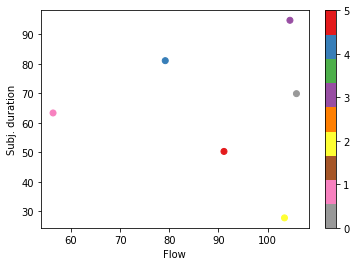

In [19]:
plt.scatter(kmeans_allperf.cluster_centers_[:,0],kmeans_allperf.cluster_centers_[:,1],c=np.arange(6),cmap=plt.cm.Set1_r)
plt.colorbar()
plt.xlabel('Flow')
plt.ylabel('Subj. duration')
plt.savefig('/home/nfarrugi/Bureau/CarolEEG/clusters.png')

In [15]:
kmeans_allperf.cluster_centers_

array([[105.88294216,  69.88712756],
       [ 56.37213313,  63.3340493 ],
       [103.44907343,  27.73197357],
       [104.55884307,  94.78026331],
       [ 79.19609122,  81.07808932],
       [ 91.14274547,  50.28155027]])

Separate learning for each perf

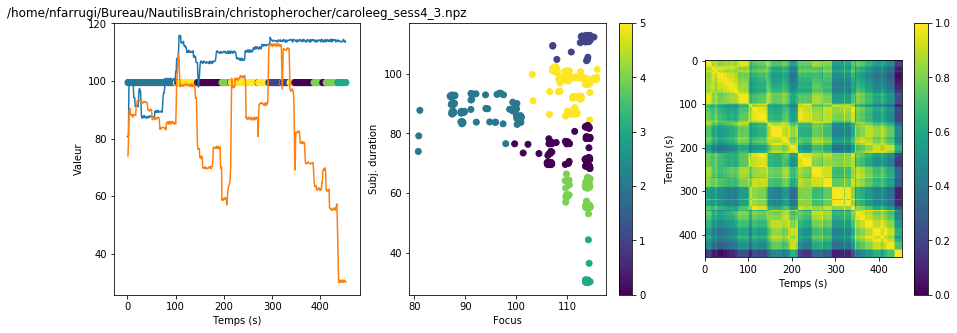

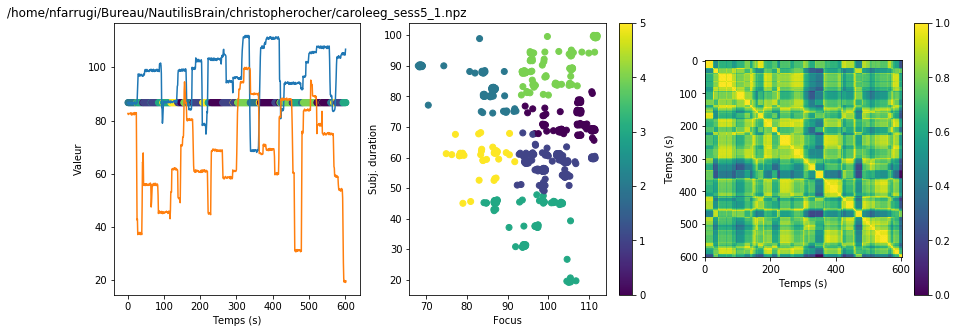

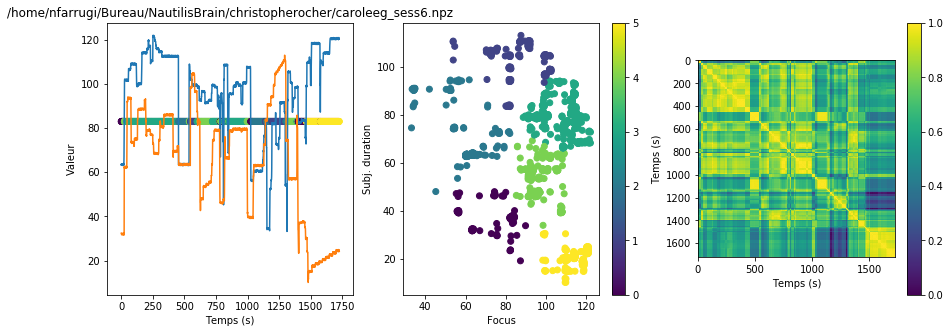

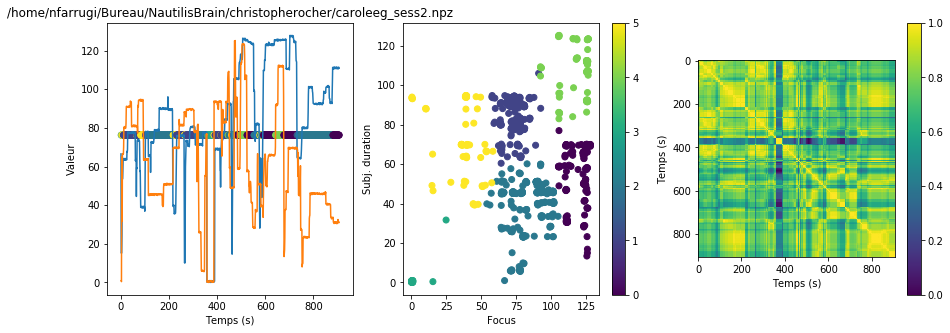

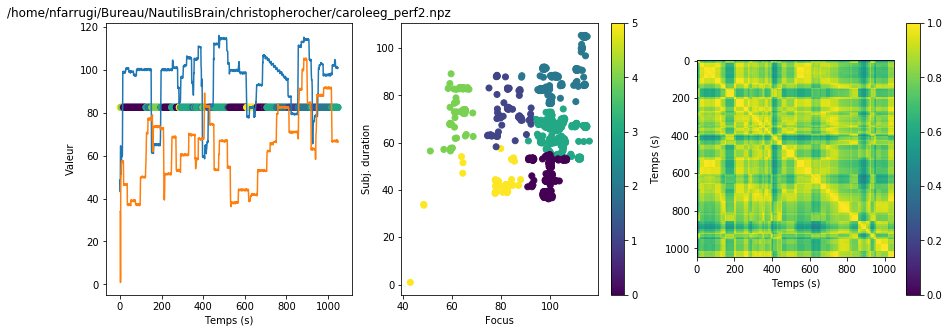

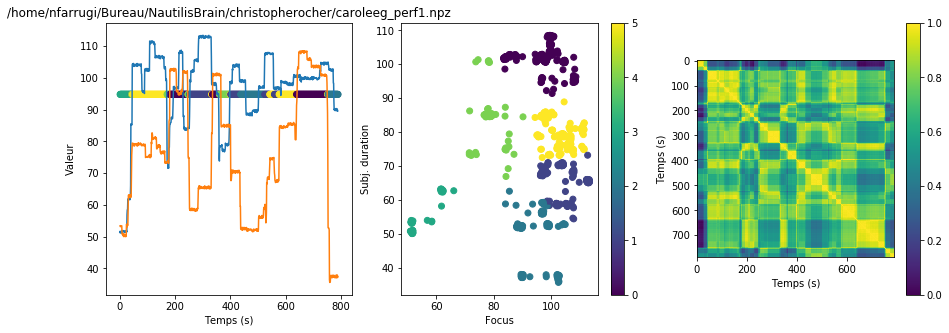

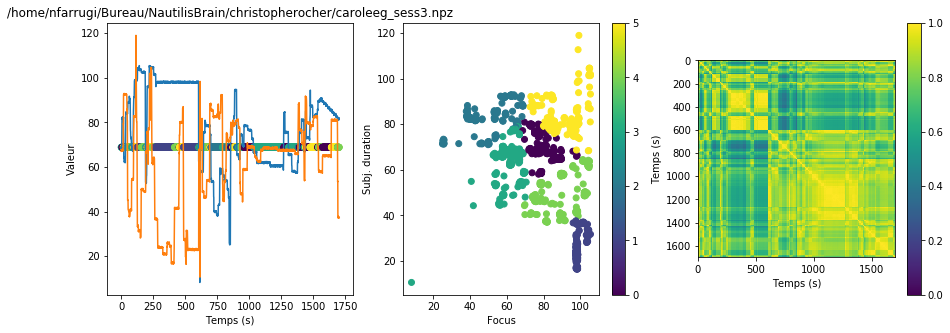

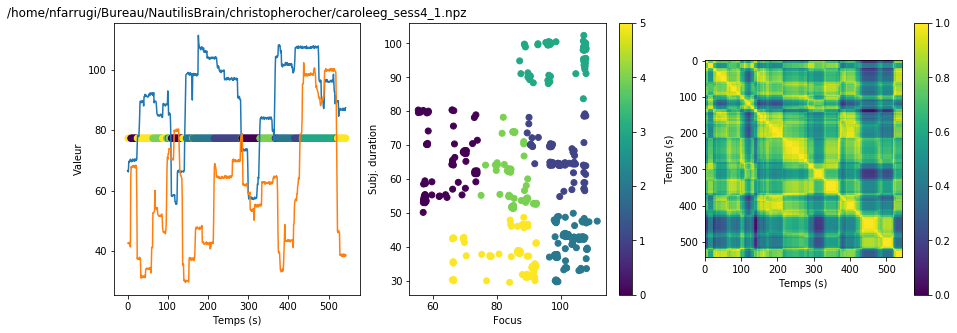

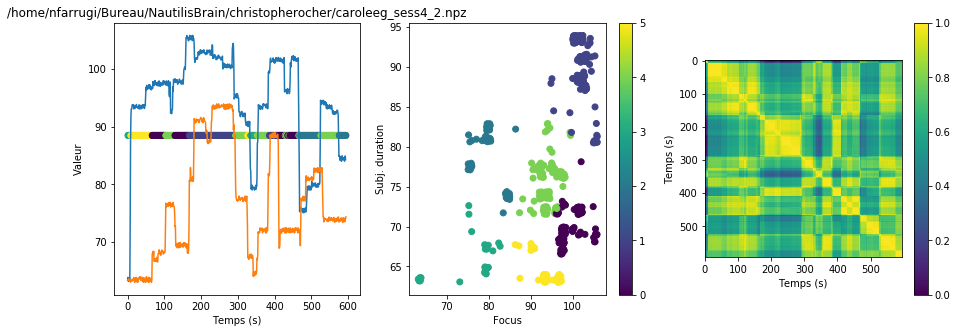

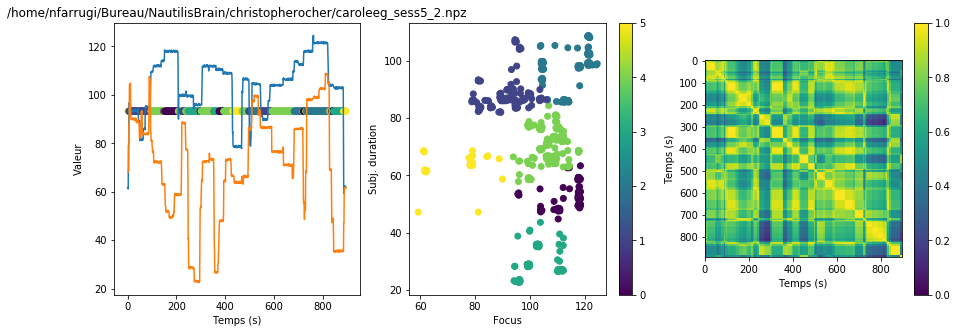

In [18]:
from analysis import quantize

from sklearn.metrics.pairwise import cosine_similarity,manhattan_distances,paired_manhattan_distances

from sklearn.cluster import KMeans

addnoise = True  

for curnpz in listnpz:
    focus = np.load(curnpz)['focus']    
    subjtime = np.load(curnpz)['subjtime']
    
    curkmeans = KMeans(n_clusters=6)

    #Quantization
    focus_q = quantize(focus,res=1,delaytime=0) 
    subt_q = quantize(subjtime,res=1,delaytime=1)
    
    
    
    maxtime = min(focus_q.shape[0],subt_q.shape[0])
    
    if addnoise:
        focus_q[:maxtime,1] += np.random.rand(maxtime)
        subt_q[:maxtime,1] += np.random.rand(maxtime)
    
    X = np.stack([focus_q[:maxtime,1],subt_q[:maxtime,1]]).T

    
    S = manhattan_distances(X)
    
    clustlabels = curkmeans.fit_predict(X)    
    
    midval = np.median(X)
    
    plt.figure(figsize=(15,5))
    plt.subplot(1,3,1)
    plt.plot(focus_q[:maxtime,0],focus_q[:maxtime,1])
    plt.plot(subt_q[:maxtime,0],subt_q[:maxtime,1])
    plt.scatter(subt_q[:maxtime,0],midval * np.ones_like(subt_q[:maxtime,0]),c=clustlabels)
    plt.ylabel('Valeur')
    plt.xlabel('Temps (s)')
    
    plt.title(curnpz)
    
    plt.subplot(1,3,2)
    plt.scatter(focus_q[:maxtime,1],subt_q[:maxtime,1],c=clustlabels)
    plt.xlabel('Focus')
    plt.ylabel('Subj. duration')
    
    plt.colorbar()
    
    
    plt.subplot(1,3,3)
    
    plt.imshow((np.max(S)-S)/np.max(S))
    plt.xlabel('Temps (s)')
    plt.ylabel('Temps (s)')
    plt.colorbar()
    
    plt.savefig("%s_clust.png" % curnpz)
    
    plt.show()
    


Learning with HMM learn . We use the lengths of the sequences. 

In [ ]:
allX.shape, lengths

In [ ]:
from hmmlearn.hmm import GaussianHMM, GMMHMM

In [ ]:
hmm = GMMHMM(n_components=5,n_mix=3)
hmm.fit(allX,lengths=lengths)

In [ ]:
samplesX,sampled_state = hmm.sample(n_samples=1000)
plt.scatter(samplesX[:,0],samplesX[:,1],c=sampled_state)
plt.xlabel('Focus')
plt.ylabel('Subj. duration')

In [ ]:
plt.plot(sampled_state)

In [ ]:
plt.scatter(samplesX[:,0])

----------
# Spectral clustering

In [15]:
curnpz = '/home/brain/Desktop/BrainSongs/audiosummary_private/christopherocher/caroleeg_perf1.npz'
focus = np.load(curnpz)['focus']

subjtime = np.load(curnpz)['subjtime']

#Quantization
focus_q = quantize(focus,res=1,delaytime=0) 
subt_q = quantize(subjtime,res=1,delaytime=1)



maxtime = min(focus_q.shape[0],subt_q.shape[0])

if addnoise:
    focus_q[:maxtime,1] += np.random.rand(maxtime)
    subt_q[:maxtime,1] += np.random.rand(maxtime)

X = np.stack([focus_q[:maxtime,1],subt_q[:maxtime,1]]).T
X.shape

(789, 2)

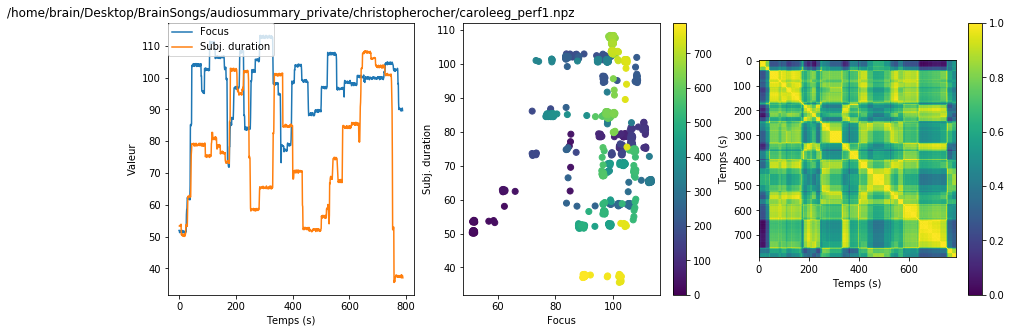

In [17]:
S = manhattan_distances(X)



plt.figure(figsize=(15,5))
plt.subplot(1,3,1)
plt.plot(focus_q[:maxtime,0],focus_q[:maxtime,1],label="Focus")
plt.plot(subt_q[:maxtime,0],subt_q[:maxtime,1],label="Subj. duration")
plt.ylabel('Valeur')
plt.xlabel('Temps (s)')
plt.legend(loc=2, borderaxespad=0.)
plt.title(curnpz)

plt.subplot(1,3,2)
plt.scatter(focus_q[:maxtime,1],subt_q[:maxtime,1],c=np.arange(maxtime))
plt.xlabel('Focus')
plt.ylabel('Subj. duration')

plt.colorbar()


plt.subplot(1,3,3)

plt.imshow((np.max(S)-S)/np.max(S))
plt.xlabel('Temps (s)')
plt.ylabel('Temps (s)')
plt.colorbar()

plt.savefig('%s.png' % curnpz)
plt.show()

In [20]:
from sklearn.metrics import silhouette_score,calinski_harabasz_score
from sklearn.cluster import SpectralClustering
from sklearn.metrics.pairwise import cosine_distances
def spectral_explore_cluster(features_vector,best_neighbors,max_cluster=10):
    metrics = []
    all_labels = []
    #Find number cluster    
    number = range(2,max_cluster +1)
    for i in tqdm(number): 
        #evaluate using calinski 
        spectral = SpectralClustering(n_clusters=i, 
                                      eigen_solver='arpack',
                                      affinity="nearest_neighbors",
                                       assign_labels="discretize",
                                      random_state=0,n_neighbors=best_neighbors).fit((features_vector))
        labels = spectral.labels_
        metrics.append(calinski_harabasz_score(features_vector, labels))
        all_labels.append(labels)
        # calinski: the higher the better
    df = pd.DataFrame(metrics,index = number, columns = ['calinski'])
   # df.plot(y=['calinski'],subplots=True,sharex=True,figsize=(10,15),fontsize=16,linewidth=4)
   
    ##best_cluster: The index where the metrics is maximum.
    best_cluster = int(df.idxmax())
    print("Best number of cluster is {:d}".format(best_cluster))
    #check dispersion of labels
    best_cluster = reduce_number_cluster(all_labels[best_cluster - 2])
    return best_cluster

def reduce_number_cluster(labels):
    counter = []
    best = len(np.unique(labels))
    for i in np.unique(labels):
        #count by label 
        counter.append((len(labels[labels==i]))/len(labels))
    
    df = pd.Series(counter,index=np.unique(labels))
    if len(df[df < 0.1]) > 0:
        print(df.mean()/df.std())
        if (df.mean()/df.std()) < 1.25:
            #Highly dispersed data, we keep the labels 
            #that have more dots than the first quartile.
            best = len(df[df > df.quantile(0.25)])
            print("Highly dispersed, final number of clusters {}".format(best))    
    return best

def spectral_explore_neighbors(features_vector,max_neighbors=30):
    metrics = []
    #Find number neighbors    
    if max_neighbors > features_vector.shape[0]:
        max_neighbors = features_vector.shape[0]//2 
    
    number = range(2,max_neighbors +1)
    for i in tqdm(number): 
        #fix n-cluster = 2, evaluate using calinski and silhouette
        spectral = SpectralClustering(n_clusters=2, 
                                      eigen_solver='arpack',
                                      affinity="nearest_neighbors",
                                      assign_labels="discretize",
                                      random_state=0,n_neighbors=i).fit((features_vector))
        labels = spectral.labels_
        metrics.append([silhouette_score(features_vector, labels,metric='cosine'),  # silhouette : best 1, worst -1 
                        calinski_harabasz_score(features_vector, labels)])   # calinski: the higher the better
       
    df = pd.DataFrame(metrics,index = number, columns = ['silhouette','calinski'])
    df.plot(y=['silhouette','calinski'],subplots=True,sharex=True,
            figsize=(10,12),fontsize=14,linewidth=2)
    
    ##best_neighbors: The mean of the indices where the first derivative of the metrics is maximum.
    best_neighbors = int(round((df.diff().idxmax().mean())))
    print("Best number of neighbors is {:d}".format(best_neighbors))
    return best_neighbors

  0%|          | 0/29 [00:00<?, ?it/s]/home/brain/miniconda3/lib/python3.7/site-packages/sklearn/manifold/spectral_embedding_.py:235: UserWarning: Graph is not fully connected, spectral embedding may not work as expected.
  warnings.warn("Graph is not fully connected, spectral embedding"
/home/brain/miniconda3/lib/python3.7/site-packages/sklearn/manifold/spectral_embedding_.py:235: UserWarning: Graph is not fully connected, spectral embedding may not work as expected.
  warnings.warn("Graph is not fully connected, spectral embedding"
  7%|▋         | 2/29 [00:00<00:01, 15.06it/s]/home/brain/miniconda3/lib/python3.7/site-packages/sklearn/manifold/spectral_embedding_.py:235: UserWarning: Graph is not fully connected, spectral embedding may not work as expected.
  warnings.warn("Graph is not fully connected, spectral embedding"
 10%|█         | 3/29 [00:00<00:02, 10.10it/s]/home/brain/miniconda3/lib/python3.7/site-packages/sklearn/manifold/spectral_embedding_.py:235: UserWarning: Graph is

 97%|█████████▋| 28/29 [00:05<00:00,  6.05it/s]/home/brain/miniconda3/lib/python3.7/site-packages/sklearn/manifold/spectral_embedding_.py:235: UserWarning: Graph is not fully connected, spectral embedding may not work as expected.
  warnings.warn("Graph is not fully connected, spectral embedding"
  0%|          | 0/9 [00:00<?, ?it/s]/home/brain/miniconda3/lib/python3.7/site-packages/sklearn/manifold/spectral_embedding_.py:235: UserWarning: Graph is not fully connected, spectral embedding may not work as expected.
  warnings.warn("Graph is not fully connected, spectral embedding"


Best number of neighbors is 10


 11%|█         | 1/9 [00:00<00:04,  1.69it/s]/home/brain/miniconda3/lib/python3.7/site-packages/sklearn/manifold/spectral_embedding_.py:235: UserWarning: Graph is not fully connected, spectral embedding may not work as expected.
  warnings.warn("Graph is not fully connected, spectral embedding"
 22%|██▏       | 2/9 [00:01<00:03,  1.84it/s]/home/brain/miniconda3/lib/python3.7/site-packages/sklearn/manifold/spectral_embedding_.py:235: UserWarning: Graph is not fully connected, spectral embedding may not work as expected.
  warnings.warn("Graph is not fully connected, spectral embedding"
 33%|███▎      | 3/9 [00:01<00:02,  2.15it/s]/home/brain/miniconda3/lib/python3.7/site-packages/sklearn/manifold/spectral_embedding_.py:235: UserWarning: Graph is not fully connected, spectral embedding may not work as expected.
  warnings.warn("Graph is not fully connected, spectral embedding"
 44%|████▍     | 4/9 [00:01<00:02,  2.47it/s]/home/brain/miniconda3/lib/python3.7/site-packages/sklearn/manifold

Best number of cluster is 3


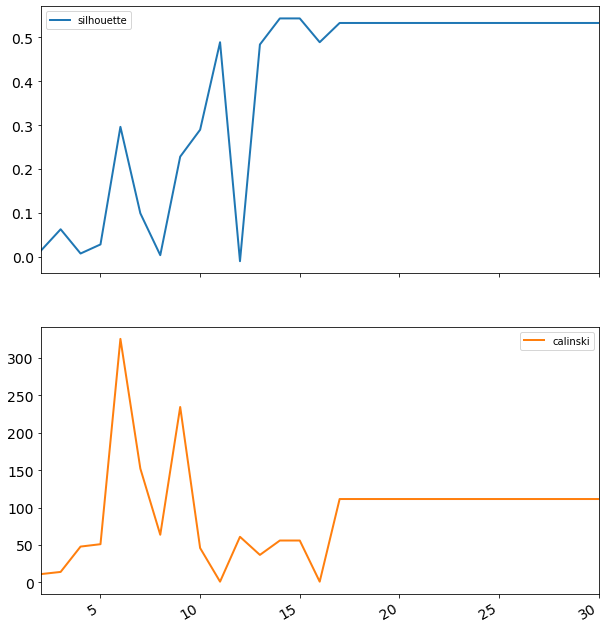

In [23]:
from tqdm import tqdm
import pandas as pd
k = spectral_explore_neighbors(X)
c = spectral_explore_cluster(X,k)

In [25]:
def make_clustering(conv,k,c):
    spectral = SpectralClustering(n_clusters=c, 
                                      eigen_solver='arpack',
                                      affinity="nearest_neighbors",
                                      assign_labels="discretize",
                                      random_state=0,n_neighbors=k).fit((conv))
    return spectral.labels_

In [27]:

labels = make_clustering(X,k,c)

/home/brain/miniconda3/lib/python3.7/site-packages/sklearn/manifold/spectral_embedding_.py:235: UserWarning: Graph is not fully connected, spectral embedding may not work as expected.
  warnings.warn("Graph is not fully connected, spectral embedding"


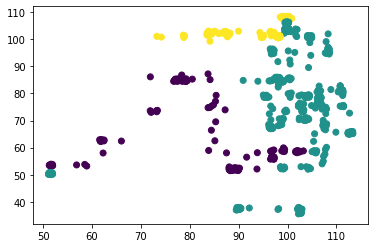

In [30]:
plt.scatter(X[:,0],X[:,1],c=labels)
